In [1]:
# !pip install vaderSentiment
# !pip install wordcloud
# !pip install textblob
# !pip install emoji
# !pip install gensim
# !pip install bertopic

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import emoji
from textblob import TextBlob
from nltk import pos_tag
from collections import Counter
from dataclasses import dataclass
from typing import List
import gensim
from gensim import corpora
from gensim.models import LdaModel
import random
from bertopic import BERTopic
from transformers import pipeline

In [3]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## 1. Data Wrangling

In [4]:
# Define text cleaning functions
def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

def lower_case(text):
    return text.lower()

def remove_tags(text):
    return re.sub(r"&lt;/?.*?&gt;", " ", text)

def remove_special_chars_and_digits(text):
    return re.sub(r"(\d|\W)+", " ", text)

def normalize_repeated_chars(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)  # e.g., "sooo" -> "soo"

def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')  # Remove emojis entirely

# Document dataclass for processing
@dataclass
class Document:
    doc_id: str
    text: str

# TokenizedDocument dataclass for storing tokenized results
@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]

# Define text preprocessing functions
def normalize_document(document: Document) -> Document:
    text = document.text
    text = remove_punctuation(text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)
    return Document(document.doc_id, text)

def normalize_documents(documents: List[Document]) -> List[Document]:
    return [normalize_document(doc) for doc in documents]

def tokenize_document(document: Document) -> TokenizedDocument:
    tokens = word_tokenize(document.text)
    return TokenizedDocument(document.doc_id, tokens)

def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
    return [tokenize_document(doc) for doc in documents]

def lemmatize_documents(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    lemmatizer = WordNetLemmatizer()
    result = []
    for doc in documents:
        tokens = [lemmatizer.lemmatize(word) for word in doc.tokens]
        result.append(TokenizedDocument(doc.doc_id, tokens))
    return result

def remove_stopwords(documents: List[TokenizedDocument], custom_stopwords: List[str] = []) -> List[TokenizedDocument]:
    stop_words = set(stopwords.words('english')).union(set(custom_stopwords))
    result = []
    for doc in documents:
        tokens = [word for word in doc.tokens if word not in stop_words]
        result.append(TokenizedDocument(doc.doc_id, tokens))
    return result


In [5]:
# Load the Airbnb Reviews Dataset
data = pd.read_csv('02_reviews_dec18.csv')

In [6]:
# Initial EDA
print(data.info())
print(data.head())
print("Missing values:\n", data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486920 entries, 0 to 486919
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     486920 non-null  int64 
 1   id             486920 non-null  int64 
 2   date           486920 non-null  object
 3   reviewer_id    486920 non-null  int64 
 4   reviewer_name  486919 non-null  object
 5   comments       486316 non-null  object
dtypes: int64(3), object(3)
memory usage: 22.3+ MB
None
   listing_id        id        date  reviewer_id reviewer_name  \
0        9835    279854  2011-05-24       560832        Miriam   
1        9835   3640746  2013-02-26      5143343      Michelle   
2        9835  23731188  2014-12-08      2478713         Karyn   
3        9835  46588875  2015-09-12     26184717      Rosalind   
4       10803   3333588  2013-01-12      4421189      Johannes   

                                            comments  
0             Very hospitable,

In [7]:
# Focus on review text and basic metadata
data = data[['id', 'comments']].dropna(subset=['comments']).reset_index(drop=True)
print(f"Dataset shape after dropping missing comments: {data.shape}")

Dataset shape after dropping missing comments: (486316, 2)


In [8]:
# Prepare Document objects
documents = [Document(str(row['id']), row['comments']) for _, row in data.iterrows()]

# Preprocessing pipeline
documents = normalize_documents(documents)
tokenized_docs = tokenize_documents(documents)
lemmatized_docs = lemmatize_documents(tokenized_docs)
# Custom stopwords (optional)
custom_stopwords = [
    'airbnb', 'melbourne', 'apartment', 'stay', 'wa', 'u', 'would','ha',
    "very", 'quite', 'little', 'much', 'few', 'so', 'such', 'definitely',
    'highly', 'also', 'everything', 'anything', 'something', 'nothing',
    'de', 'la', 'e', 'n'
]

final_docs = remove_stopwords(lemmatized_docs, custom_stopwords)

# Get all tokens
all_tokens = [token for doc in final_docs for token in doc.tokens]

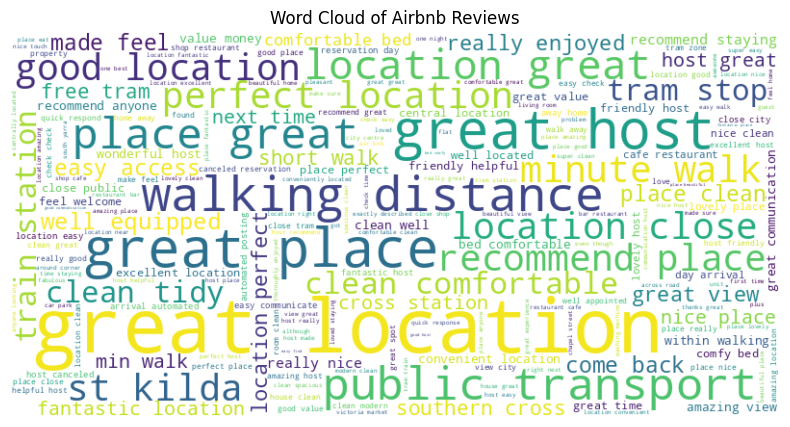

In [9]:
# Word Cloud and Top N Words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_tokens))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Airbnb Reviews')
plt.show()


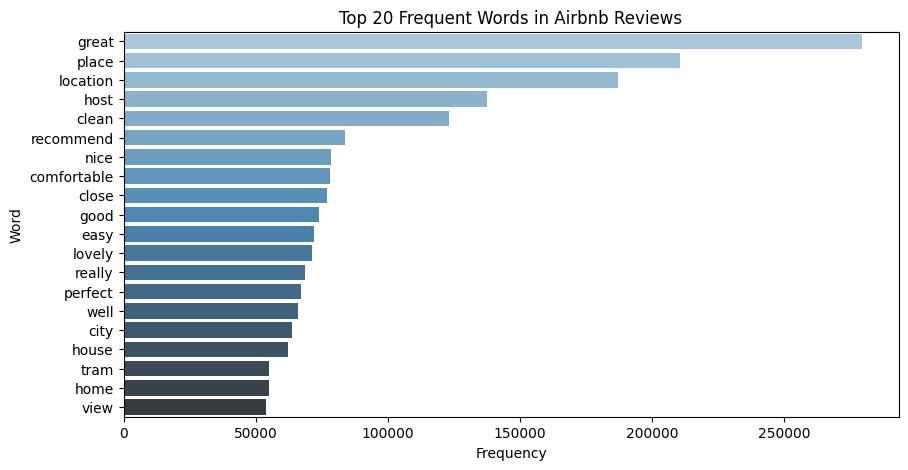

In [10]:
# Top 20 Word Frequencies
word_freq = Counter(all_tokens)
top_words = word_freq.most_common(20)

# Plot top 20 words
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
plt.figure(figsize=(10, 5))
sns.barplot(x='Frequency', y='Word', data=top_words_df, palette='Blues_d')
plt.title('Top 20 Frequent Words in Airbnb Reviews')
plt.show()

## 2. Aspect Extraction

### 2.1 Rule-Based Extraction

In [11]:
# Define common aspect keywords for Airbnb reviews
aspect_keywords = {
    'location': ['location', 'distance', 'walk', 'tram', 'station', 'area', 'neighborhood'],
    'cleanliness': ['clean', 'tidy', 'spotless', 'hygiene'],
    'communication': ['host', 'communication', 'respond', 'message', 'reply'],
    'amenities': ['kitchen', 'bathroom', 'wifi', 'facility', 'bed', 'equipment'],
    'comfort': ['comfortable', 'bed', 'room', 'spacious', 'cozy'],
    'value': ['price', 'affordable', 'value', 'expensive', 'cheap'],
    'checkin': ['check', 'arrival', 'key', 'instructions'],
    'recommendation': ['recommend', 'would', 'definitely'],
    'host': ['host', 'friendly', 'helpful', 'kind', 'welcoming']
}

# Function to extract aspects based on keyword matching
def extract_aspects_from_tokens(tokenized_doc: TokenizedDocument) -> List[str]:
    aspects_found = []
    for aspect, keywords in aspect_keywords.items():
        if any(word in tokenized_doc.tokens for word in keywords):
            aspects_found.append(aspect)
    return aspects_found

# Apply rule-based aspect extraction
rule_aspects = [extract_aspects_from_tokens(doc) for doc in final_docs]


### 2.2 LDA Topic Modeling

In [12]:
# Prepare corpus for LDA
texts = [doc.tokens for doc in final_docs]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10, random_state=42)

# Assign dominant topic and probability for each document
lda_topics = []  # Dominant topic
lda_probs = []   # Corresponding topic probability

for i, row in enumerate(lda_model[corpus]):
    # Sort topics by probability in descending order
    sorted_row = sorted(row, key=lambda x: -x[1])
    dominant_topic = sorted_row[0][0]         # Topic with highest probability
    dominant_prob = sorted_row[0][1]          # Highest probability value
    lda_topics.append(dominant_topic)
    lda_probs.append(dominant_prob)

# Print topics (Top 10 words per topic)
print("\nLDA Topics Overview:")
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx}: {topic}")


LDA Topics Overview:
Topic 0: 0.036*"close" + 0.034*"great" + 0.028*"location" + 0.024*"tram" + 0.024*"place" + 0.023*"city" + 0.018*"walk" + 0.016*"clean" + 0.015*"easy" + 0.015*"station"
Topic 1: 0.033*"place" + 0.019*"home" + 0.017*"recommend" + 0.017*"host" + 0.017*"beautiful" + 0.015*"amazing" + 0.015*"great" + 0.014*"perfect" + 0.013*"back" + 0.012*"lovely"
Topic 2: 0.013*"bed" + 0.012*"room" + 0.010*"check" + 0.010*"kitchen" + 0.009*"good" + 0.009*"night" + 0.008*"bathroom" + 0.008*"one" + 0.007*"bedroom" + 0.006*"bit"
Topic 3: 0.116*"great" + 0.077*"location" + 0.052*"host" + 0.049*"place" + 0.037*"clean" + 0.028*"good" + 0.019*"communication" + 0.019*"view" + 0.019*"easy" + 0.017*"check"
Topic 4: 0.073*"house" + 0.058*"nice" + 0.040*"room" + 0.033*"place" + 0.030*"clean" + 0.029*"really" + 0.025*"friendly" + 0.024*"host" + 0.019*"lovely" + 0.016*"good"


### 2.3 BERTopic

In [13]:
# Prepare text data for BERTopic
# Convert token lists back to strings for BERTopic input
final_texts = [' '.join(doc.tokens) for doc in final_docs]

# Set random seed for reproducibility
random.seed(42)

# Define sample size based on RAM availability and dataset size
sample_size = 10000  # Start with 10,000 samples; adjust as needed

# Check if sampling is needed based on dataset size
if len(final_texts) > sample_size:
    # Randomly select unique indices for sampling
    sampled_indices = random.sample(range(len(final_texts)), sample_size)
    # Extract the sampled text data
    sampled_texts = [final_texts[i] for i in sampled_indices]
else:
    # If dataset is small enough, use all data
    sampled_texts = final_texts
    sampled_indices = list(range(len(final_texts)))

# Initialize BERTopic model
bertopic_model = BERTopic(language="english", verbose=True)

# Fit BERTopic model on sampled text data
bertopic_topics, bertopic_probs = bertopic_model.fit_transform(sampled_texts)

# Display top 15 topics
top_n = 15
topics_info = bertopic_model.get_topic_info().head(top_n)
print(topics_info)

2025-06-03 20:39:16,259 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2025-06-03 20:39:33,921 - BERTopic - Embedding - Completed ✓
2025-06-03 20:39:33,925 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-03 20:40:17,725 - BERTopic - Dimensionality - Completed ✓
2025-06-03 20:40:17,726 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-03 20:40:18,213 - BERTopic - Cluster - Completed ✓
2025-06-03 20:40:18,219 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-03 20:40:18,494 - BERTopic - Representation - Completed ✓


    Topic  Count                                       Name  \
0      -1   4835                 -1_place_host_great_lovely   
1       0    373                      0_cbd_tram_walk_close   
2       1    288                   1_tram_free_station_zone   
3       2    230                         2_lv_nil_dghh_goof   
4       3    207                 3_clean_tidy_location_nice   
5       4    184                 4_restaurant_cafe_bar_shop   
6       5    173             5_bed_comfy_comfortable_pillow   
7       6    168        6_communication_easy_great_location   
8       7    151                      7_kilda_st_beach_tram   
9       8    115                       8_pool_gym_sauna_spa   
10      9    107            9_fitzroy_collingwood_bar_heart   
11     10    103  10_automated_posting_canceled_reservation   
12     11    100                  11_value_money_price_deal   
13     12     92           12_family_house_location_stylish   
14     13     83           13_view_awesome_amazing_loca

In [14]:
# Display representative words for each topic
for i in range(top_n):
    print(f"\nTopic {i}:")
    print(bertopic_model.get_topic(i))


Topic 0:
[('cbd', 0.06473232485460484), ('tram', 0.011717198185332985), ('walk', 0.010111791914468529), ('close', 0.007831502340573383), ('within', 0.0076864067821666646), ('location', 0.007670456967839967), ('minute', 0.007554958477026778), ('heart', 0.007465229429586263), ('easy', 0.007438793684740869), ('place', 0.007366277648234702)]

Topic 1:
[('tram', 0.04999575090752516), ('free', 0.02780358976542241), ('station', 0.01736573499844242), ('zone', 0.0168733372743182), ('stop', 0.01676245669716307), ('train', 0.015311647453536569), ('walk', 0.012985328497587953), ('city', 0.012238133815952705), ('easy', 0.011675917751082258), ('close', 0.011306229496722156)]

Topic 2:
[('lv', 0.5721380862824563), ('nil', 0.5721380862824563), ('dghh', 0.5721380862824563), ('goof', 0.5721380862824563), ('cuan', 0.5721380862824563), ('bu', 0.5188643345757201), ('ash', 0.4124973220285991), ('dilin', 0.40348216503524775), ('promised', 0.35491961658029414), ('na', 0.350567655550134)]

Topic 3:
[('clean',

In [15]:
# Visualize top topics as a bar chart
bertopic_model.visualize_barchart(top_n_topics=top_n).show()

# Visualize the topic clusters
bertopic_model.visualize_topics().show()

# Create a DataFrame with sampled data and topic assignments
bertopic_df = pd.DataFrame({
    'doc_id': [final_docs[i].doc_id for i in sampled_indices],  # Get original doc_id
    'cleaned_text': sampled_texts,
    'bertopic_topic': bertopic_topics,
    'bertopic_probability': bertopic_probs
})

# Save to CSV
bertopic_df.to_csv('02_bertopic_results.csv', index=False)

print("BERTopic results saved to 'bertopic_results.csv'.")

BERTopic results saved to 'bertopic_results.csv'.


In [16]:
print("\nSample Reviews with BERTopic Assignment:")
for i in random.sample(range(len(bertopic_df)), 5):
    print(f"Doc ID: {bertopic_df.loc[i, 'doc_id']}, BERTopic Topic: {bertopic_df.loc[i, 'bertopic_topic']}, BERTopic Probability :{bertopic_df.loc[i, 'bertopic_probability']}")
    print(f"Text: {bertopic_df.loc[i, 'cleaned_text'][:200]}...\n")


Sample Reviews with BERTopic Assignment:
Doc ID: 240473884, BERTopic Topic: -1, BERTopic Probability :0.0
Text: nice place worked perfectly visiting university...

Doc ID: 123353494, BERTopic Topic: 70, BERTopic Probability :0.7754595277402095
Text: joseph right city centre ideal transit need get somewhere next day caught tram block ferry terminal go across tasmania perfect airport train station bus terminal readily available need city joseph mad...

Doc ID: 239463175, BERTopic Topic: 15, BERTopic Probability :0.8629712519064591
Text: excellent place couple perhaps one child well couple perfect question regarding dealing dryer jonathan came decoded within minute excellent communication excellent location surprise door lock need bit...

Doc ID: 33236290, BERTopic Topic: -1, BERTopic Probability :0.0
Text: review similar booking excellent...

Doc ID: 56243004, BERTopic Topic: -1, BERTopic Probability :0.0
Text: simone adam pleasant arrived showed studio thing worked let use phone call c

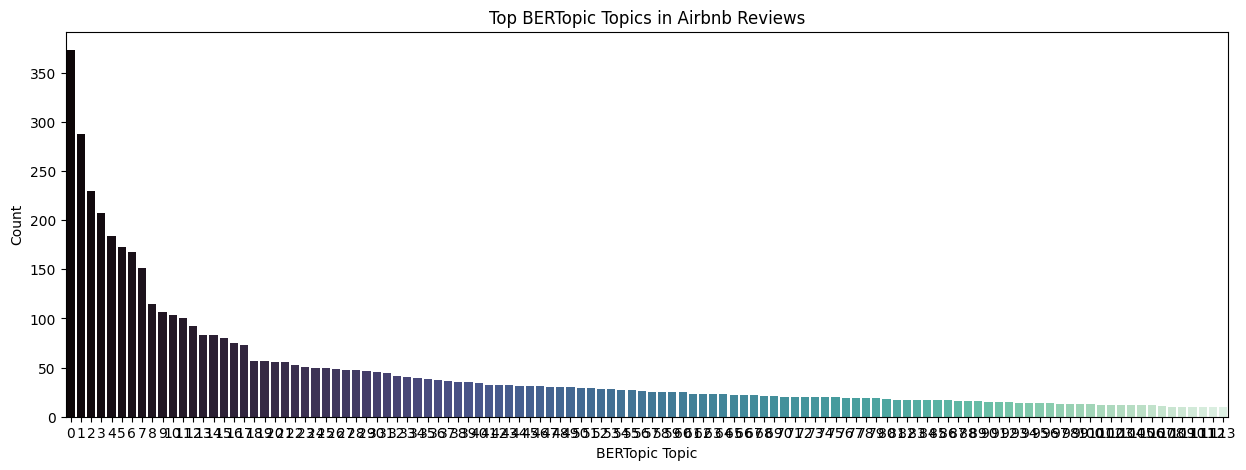

In [17]:
# Excluded Topic -1
filtered_df = bertopic_df[bertopic_df['bertopic_topic'] != -1]

bertopic_topic_counts = filtered_df['bertopic_topic'].value_counts().reset_index()
bertopic_topic_counts.columns = ['BERTopic Topic', 'Count']

plt.figure(figsize=(15, 5))
sns.barplot(x='BERTopic Topic', y='Count', data=bertopic_topic_counts, palette='mako')
plt.title('Top BERTopic Topics in Airbnb Reviews')
plt.show()

### 2.4 Summary of three models

In [18]:
# Create final aspect DataFrame
aspect_df = pd.DataFrame({
    'doc_id': [doc.doc_id for doc in final_docs],
    'cleaned_text': final_texts,
    'rule_aspects': rule_aspects,
    'lda_topic': lda_topics,
    'lda_probability': lda_probs
    # 'bertopic_topic': bertopic_topics,
    # 'bertopic_probability': bertopic_probs
})

# Show sample rows
print("\nSample Aspect DataFrame:")
print(aspect_df.head())


Sample Aspect DataFrame:
     doc_id                                       cleaned_text  \
0    279854                             hospitable appreciated   
1   3640746  beautiful house lovely quiet neighbourhood min...   
2  23731188  first time using great going party area accomm...   
3  46588875  visiting spend time son daughter law new baby ...   
4   3333588  convenient lindsay appartment brunswick couple...   

                                        rule_aspects  lda_topic  \
0                                                 []          1   
1                [location, comfort, recommendation]          0   
2           [location, communication, comfort, host]          2   
3  [location, communication, amenities, comfort, ...          0   
4                              [communication, host]          1   

   lda_probability  
0         0.503247  
1         0.445951  
2         0.412163  
3         0.412343  
4         0.431174  


In [19]:
# Show sample reviews
print("\nSample Reviews with Extracted Aspects (Rule-Based):")
for i in random.sample(range(len(aspect_df)), 5):
    print(f"Doc ID: {aspect_df.loc[i, 'doc_id']}")
    print(f"Rule-Based Aspects: {aspect_df.loc[i, 'rule_aspects']}")
    print(f"Text: {aspect_df.loc[i, 'cleaned_text'][:200]}...\n")


Sample Reviews with Extracted Aspects (Rule-Based):
Doc ID: 353203233
Rule-Based Aspects: []
Text: ...

Doc ID: 273070945
Rule-Based Aspects: ['location', 'communication', 'host']
Text: anne generous enough let host photo shoot one afternoon fabulous terrific host made feel welcome offering plenty tea coffee food absolutely beautiful best location thank next time back night...

Doc ID: 44475689
Rule-Based Aspects: ['communication', 'recommendation']
Text: linda unfortunately greet son chris great fantastic communication prior booking amazing richmond studio felt like stepped new york loft amazing view super close great restaurant else could possibly ne...

Doc ID: 253595974
Rule-Based Aspects: ['communication', 'recommendation']
Text: great place close well great amenity pool sauna spa gym grace particular amazing quick reply accomodating recommend anyone...

Doc ID: 164600051
Rule-Based Aspects: ['location', 'amenities', 'comfort']
Text: comfortable great central location yet beaten 

In [20]:
print("\nSample Reviews with LDA Topic Assignment:")
for i in random.sample(range(len(aspect_df)), 5):
    print(f"Doc ID: {aspect_df.loc[i, 'doc_id']}, LDA Topic: {aspect_df.loc[i, 'lda_topic']}")
    print(f"Text: {aspect_df.loc[i, 'cleaned_text'][:200]}...\n")


Sample Reviews with LDA Topic Assignment:
Doc ID: 341805618, LDA Topic: 3
Text: great location value money single couple clean linda quick respond...

Doc ID: 242933857, LDA Topic: 1
Text: annemarie could make perfect lovely person home welcoming comfortable recommended...

Doc ID: 160622560, LDA Topic: 0
Text: wenfang place minute walk footscray train station close good vietnamese turkish cuisine great western cafe cum restaurant station hotel five minute walk house besides near cbd wenfang place allows ven...

Doc ID: 173163096, LDA Topic: 2
Text: high expectation given great review met every level good location great communication promised sure...

Doc ID: 215819094, LDA Topic: 3
Text: une superbe maison familial quelques minute marche mer chambre est parfaite pour un voyageur passage espace un peu restreint si vous avez gross valise mais vous pouvez profiter du reste maison sans pr...



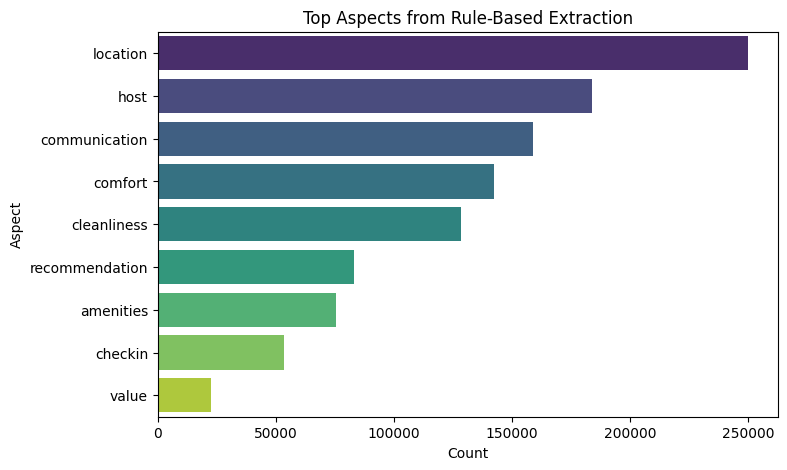

In [21]:
# Visualization
# Flatten and count aspects
all_rule_aspects = [aspect for aspects in aspect_df['rule_aspects'].dropna() for aspect in aspects]
rule_aspect_counts = pd.Series(all_rule_aspects).value_counts().reset_index()
rule_aspect_counts.columns = ['Aspect', 'Count']

plt.figure(figsize=(8, 5))
sns.barplot(x='Count', y='Aspect', data=rule_aspect_counts, palette='viridis')
plt.title('Top Aspects from Rule-Based Extraction')
plt.show()

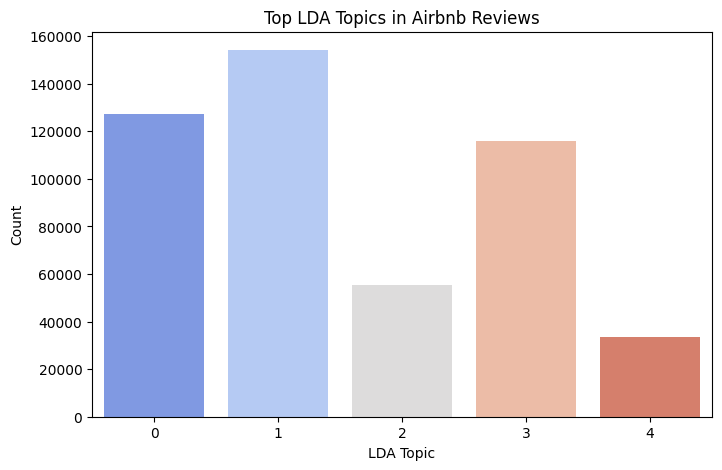

In [22]:
lda_topic_counts = aspect_df['lda_topic'].value_counts().reset_index()
lda_topic_counts.columns = ['LDA Topic', 'Count']

plt.figure(figsize=(8, 5))
sns.barplot(x='LDA Topic', y='Count', data=lda_topic_counts, palette='coolwarm')
plt.title('Top LDA Topics in Airbnb Reviews')
plt.show()

## 3. Sentiment Analysis


### 3.1 VADER Sentiment Analysis

In [23]:
# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Apply VADER sentiment analysis to each review
vader_results = []
for doc in final_docs:
    text = ' '.join(doc.tokens)
    sentiment = analyzer.polarity_scores(text)
    vader_results.append({
        'doc_id': doc.doc_id,
        'text': text,
        'vader_neg': sentiment['neg'],
        'vader_neu': sentiment['neu'],
        'vader_pos': sentiment['pos'],
        'vader_compound': sentiment['compound'],
        'vader_sentiment': 'positive' if sentiment['compound'] > 0.05 else 'negative' if sentiment['compound'] < -0.05 else 'neutral'
    })

vader_df = pd.DataFrame(vader_results)


In [24]:
# Merge bertopic to the total dataframe, and merge VADER sentiment with aspect DataFrame
bertopic_df.drop(columns=['cleaned_text'], inplace=True)
aspect_df = aspect_df.merge(bertopic_df, on='doc_id', how='left')
aspect_sentiment_df = aspect_df.merge(vader_df[['doc_id', 'vader_sentiment']], on='doc_id', how='left')


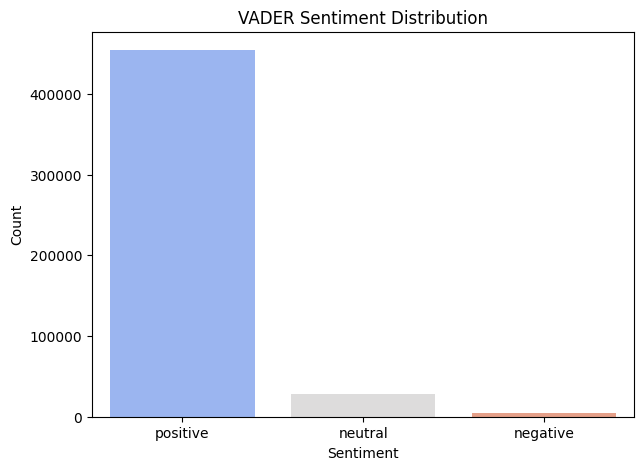

In [25]:
# Visualize sentiment distribution
plt.figure(figsize=(7, 5))
sns.countplot(x='vader_sentiment', data=aspect_sentiment_df, palette='coolwarm')
plt.title('VADER Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

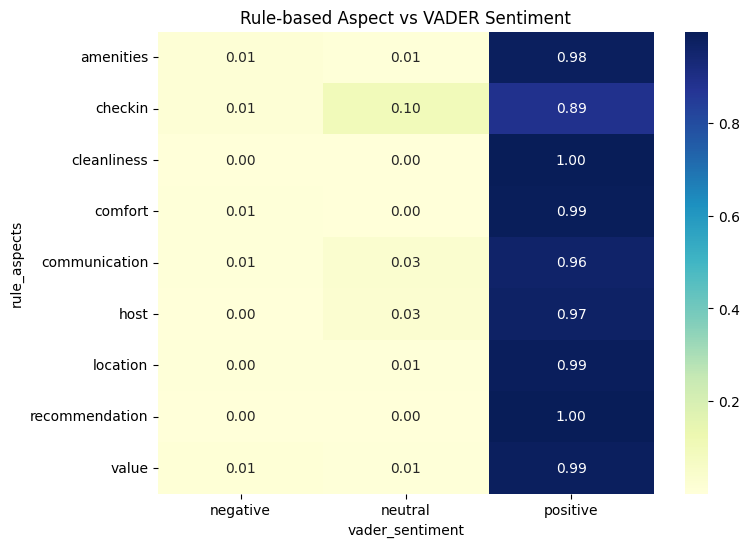

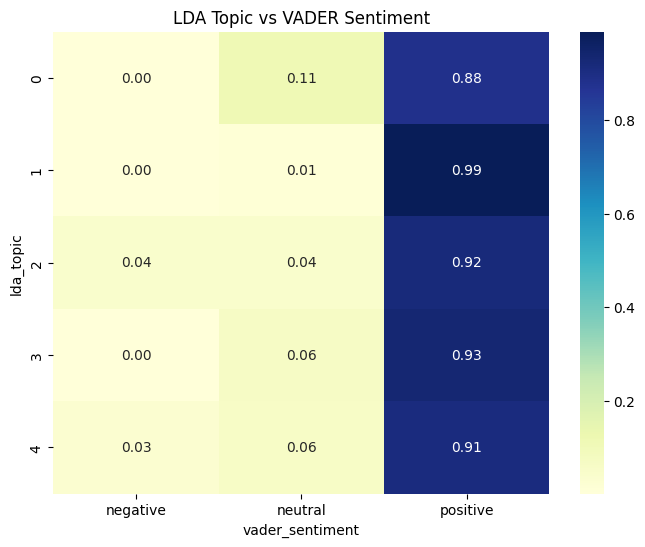

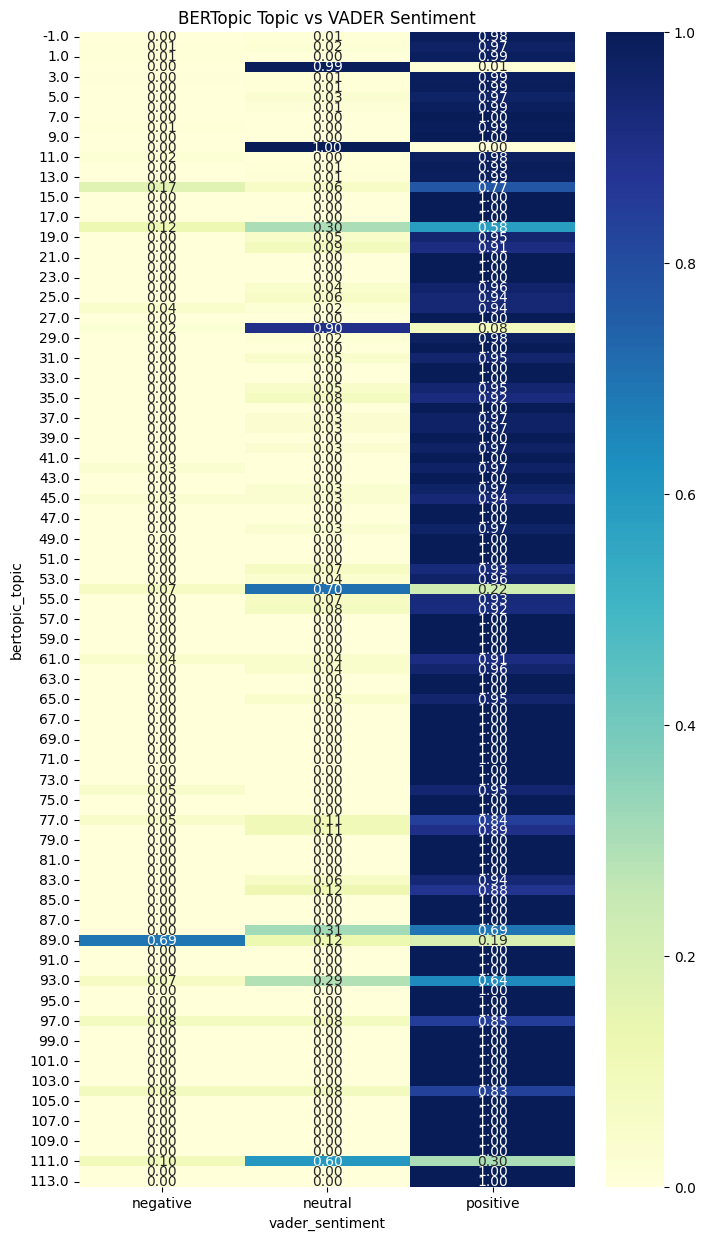

In [34]:
# Aspect-Sentiment Cross Analysis (VADER)

# Rule-based Aspects
rule_aspect_sentiment = aspect_sentiment_df.explode('rule_aspects').dropna(subset=['rule_aspects'])
cross_rule = pd.crosstab(rule_aspect_sentiment['rule_aspects'], rule_aspect_sentiment['vader_sentiment'], normalize='index')

plt.figure(figsize=(8, 6))
sns.heatmap(cross_rule, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Rule-based Aspect vs VADER Sentiment')
plt.show()

# LDA Topics
lda_cross = pd.crosstab(aspect_sentiment_df['lda_topic'], aspect_sentiment_df['vader_sentiment'], normalize='index')

plt.figure(figsize=(8, 6))
sns.heatmap(lda_cross, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('LDA Topic vs VADER Sentiment')
plt.show()

# BERTopic Topics
# Only show the top 15 topics
bertopic_cross = pd.crosstab(aspect_sentiment_df['bertopic_topic'], aspect_sentiment_df['vader_sentiment'], normalize='index')

plt.figure(figsize=(8, 15))
sns.heatmap(bertopic_cross, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('BERTopic Topic vs VADER Sentiment')
plt.show()

In [27]:
# Display Sample Aspect-Sentiment Reviews
print("\nSample Aspect-Sentiment Reviews (VADER):")
for i in range(5):
    row = aspect_sentiment_df.iloc[i]
    print(f"Doc ID: {row['doc_id']}, Rule Aspect: {row['rule_aspects']}, LDA Topic: {row['lda_topic']}, BERTopic Topic: {row['bertopic_topic']}, VADER Sentiment: {row['vader_sentiment']}")


Sample Aspect-Sentiment Reviews (VADER):
Doc ID: 279854, Rule Aspect: [], LDA Topic: 1, BERTopic Topic: nan, VADER Sentiment: positive
Doc ID: 3640746, Rule Aspect: ['location', 'comfort', 'recommendation'], LDA Topic: 0, BERTopic Topic: nan, VADER Sentiment: positive
Doc ID: 23731188, Rule Aspect: ['location', 'communication', 'comfort', 'host'], LDA Topic: 2, BERTopic Topic: nan, VADER Sentiment: positive
Doc ID: 46588875, Rule Aspect: ['location', 'communication', 'amenities', 'comfort', 'host'], LDA Topic: 0, BERTopic Topic: nan, VADER Sentiment: positive
Doc ID: 3333588, Rule Aspect: ['communication', 'host'], LDA Topic: 1, BERTopic Topic: nan, VADER Sentiment: positive


### 3.2 BERT Sentiment Analysis (HuggingFace Transformers)

In [28]:
# Initialize BERT classifier (use device=0 for GPU, truncation during call)
bert_classifier = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=0  # Set to 0 for GPU
)

# Filter non-null texts
texts = aspect_df['cleaned_text'].dropna().tolist()

# Run BERT sentiment in batch mode with truncation and batch_size
results = bert_classifier(texts, truncation=True, batch_size=16)  # Here is batch_size!

# Extract sentiment and score
bert_sentiments = [r['label'] for r in results]
bert_scores = [r['score'] for r in results]

# Assign back to aspect_df (be careful with index)
aspect_df.loc[aspect_df['cleaned_text'].notnull(), 'bert_sentiment'] = bert_sentiments
aspect_df.loc[aspect_df['cleaned_text'].notnull(), 'bert_score'] = bert_scores

# Map labels to Positive/Negative/Neutral
aspect_df['bert_sentiment_mapped'] = aspect_df['bert_sentiment'].map({
    'POSITIVE': 'Positive',
    'NEGATIVE': 'Negative'
}).fillna('Neutral')

# Sample output
print("\nSample BERT Sentiment Results:")
print(aspect_df[['doc_id', 'cleaned_text', 'bert_sentiment', 'bert_score']].head())

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0



Sample BERT Sentiment Results:
     doc_id                                       cleaned_text bert_sentiment  \
0    279854                             hospitable appreciated       POSITIVE   
1   3640746  beautiful house lovely quiet neighbourhood min...       POSITIVE   
2  23731188  first time using great going party area accomm...       POSITIVE   
3  46588875  visiting spend time son daughter law new baby ...       POSITIVE   
4   3333588  convenient lindsay appartment brunswick couple...       POSITIVE   

   bert_score  
0    0.999689  
1    0.999700  
2    0.999448  
3    0.999134  
4    0.895512  


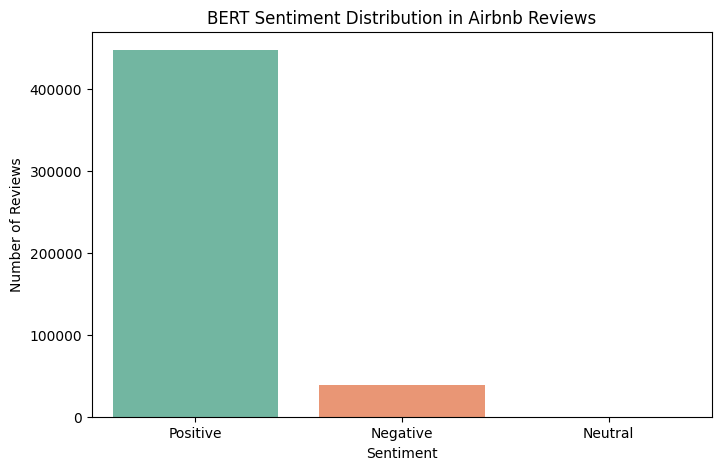

In [29]:
# Sentiment Distribution Bar Plot
plt.figure(figsize=(8,5))
sns.countplot(x='bert_sentiment_mapped', data=aspect_df, palette='Set2', order=['Positive', 'Negative', 'Neutral'])
plt.title("BERT Sentiment Distribution in Airbnb Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

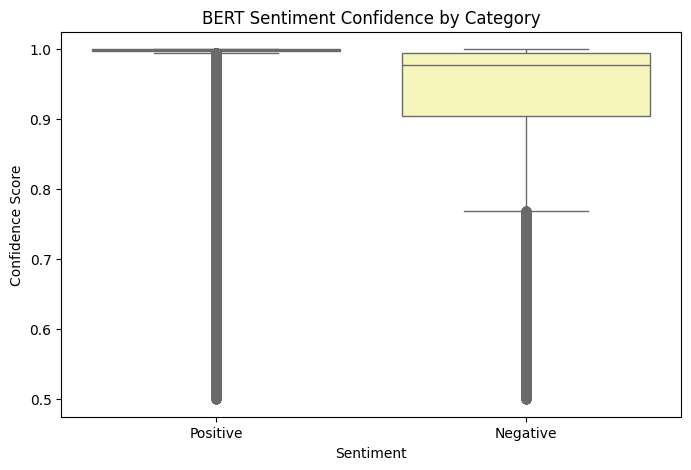

In [30]:
# Average Sentiment Score per Category
plt.figure(figsize=(8,5))
sns.boxplot(x='bert_sentiment_mapped', y='bert_score', data=aspect_df, palette='Set3')
plt.title("BERT Sentiment Confidence by Category")
plt.xlabel("Sentiment")
plt.ylabel("Confidence Score")
plt.show()

In [31]:
# Aspect-Sentiment Cross Analysis (BERT)
# For each aspect method (Rule, LDA, BERTopic), calculate sentiment proportions

def cross_tabulate_aspect_sentiment(aspect_col):
    df = aspect_df.explode(aspect_col).dropna(subset=[aspect_col])
    sentiment_counts = df.groupby([aspect_col, 'bert_sentiment_mapped']).size().unstack(fill_value=0)
    sentiment_pct = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100
    return sentiment_counts, sentiment_pct

# Rule-based Aspect + BERT Sentiment
rule_sentiment_counts, rule_sentiment_pct = cross_tabulate_aspect_sentiment('rule_aspects')
print("\nRule-based Aspect Sentiment Counts:\n", rule_sentiment_counts)
print("\nRule-based Aspect Sentiment Percentages:\n", rule_sentiment_pct)

# LDA Topic + BERT Sentiment
lda_sentiment_counts, lda_sentiment_pct = cross_tabulate_aspect_sentiment('lda_topic')
print("\nLDA Topic Sentiment Counts:\n", lda_sentiment_counts)
print("\nLDA Topic Sentiment Percentages:\n", lda_sentiment_pct)

# BERTopic + BERT Sentiment
bertopic_sentiment_counts, bertopic_sentiment_pct = cross_tabulate_aspect_sentiment('bertopic_topic')
print("\nBERTopic Aspect Sentiment Counts:\n", bertopic_sentiment_counts)
print("\nBERTopic Aspect Sentiment Percentages:\n", bertopic_sentiment_pct)


Rule-based Aspect Sentiment Counts:
 bert_sentiment_mapped  Negative  Positive
rule_aspects                             
amenities                  8440     66987
checkin                   11425     42084
cleanliness                7887    120422
comfort                    9173    133228
communication             14679    144379
host                      14973    169141
location                  16207    233944
recommendation             3107     79930
value                      2742     19726

Rule-based Aspect Sentiment Percentages:
 bert_sentiment_mapped   Negative   Positive
rule_aspects                               
amenities              11.189627  88.810373
checkin                21.351548  78.648452
cleanliness             6.146880  93.853120
comfort                 6.441668  93.558332
communication           9.228709  90.771291
host                    8.132461  91.867539
location                6.478887  93.521113
recommendation          3.741706  96.258294
value            

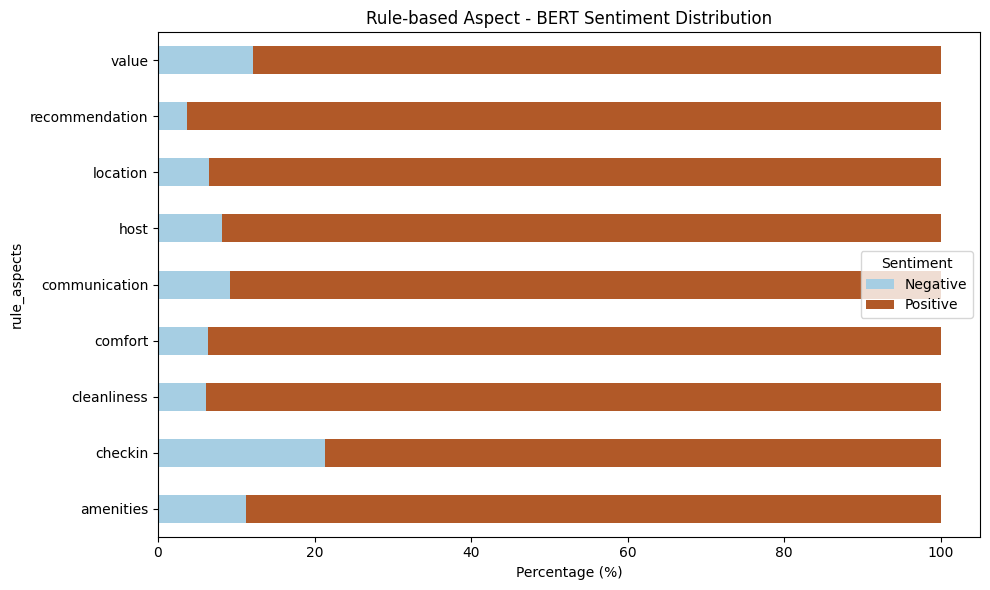

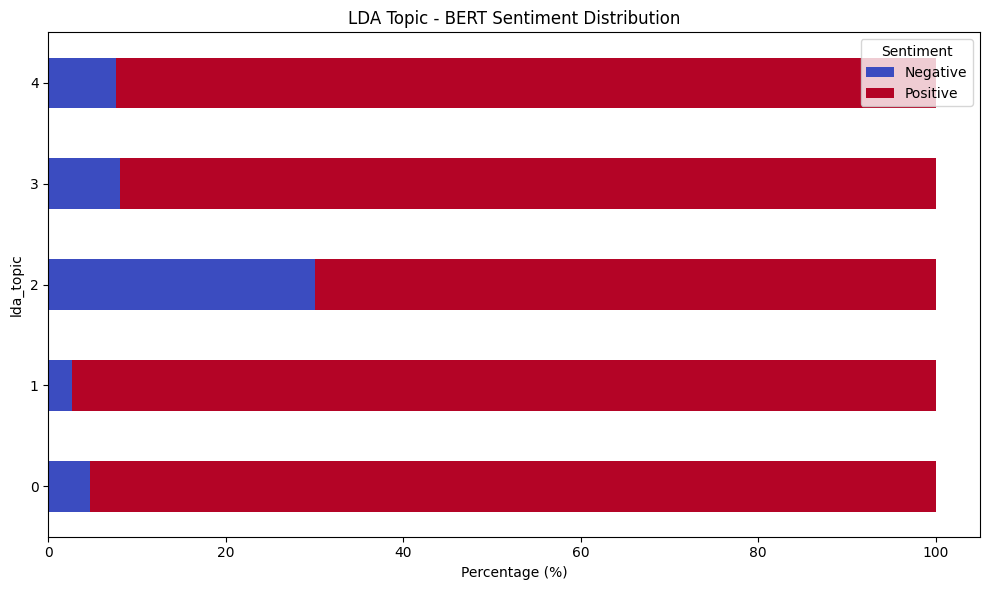

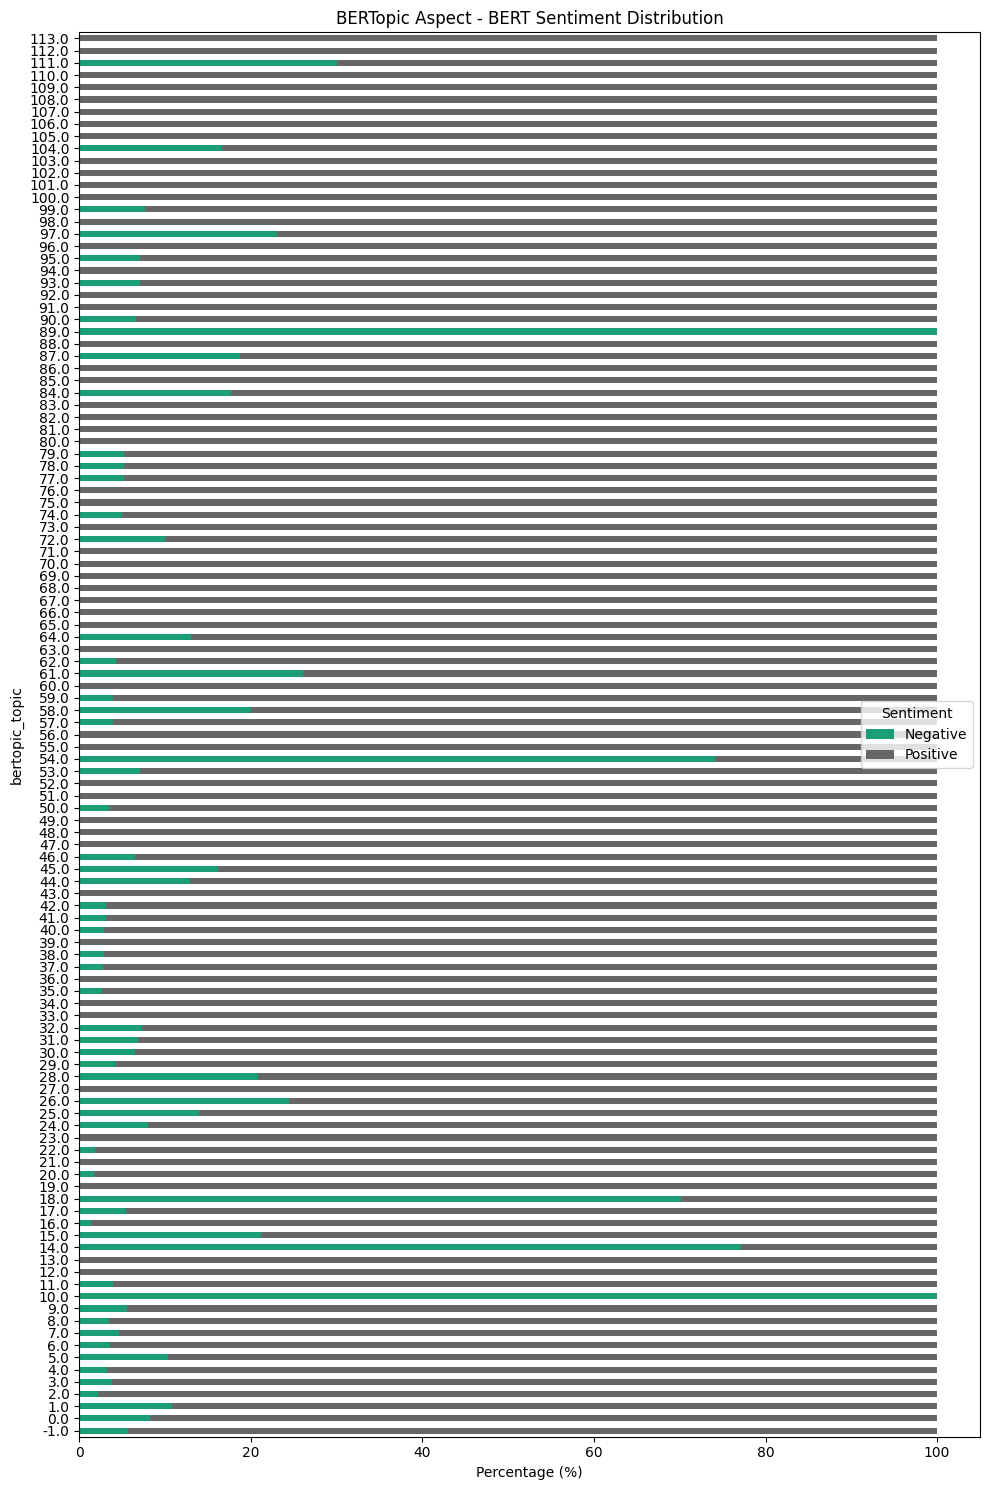

In [35]:
# Visualize: Rule-based Aspect + BERT Sentiment
rule_sentiment_pct.plot(kind='barh', stacked=True, figsize=(10,6), colormap='Paired')
plt.title("Rule-based Aspect - BERT Sentiment Distribution")
plt.xlabel("Percentage (%)")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

# Visualize: LDA Topic + BERT Sentiment
lda_sentiment_pct.plot(kind='barh', stacked=True, figsize=(10,6), colormap='coolwarm')
plt.title("LDA Topic - BERT Sentiment Distribution")
plt.xlabel("Percentage (%)")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

# Visualize: BERTopic + BERT Sentiment
# Only show top 15 topics
bertopic_sentiment_pct.plot(kind='barh', stacked=True, figsize=(10,15), colormap='Dark2')
plt.title("BERTopic Aspect - BERT Sentiment Distribution")
plt.xlabel("Percentage (%)")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


In [33]:
# Sample Aspect-Sentiment Interpretations

print("\nSample Aspect-Sentiment Reviews (Rule-based):")
for idx, row in aspect_df.explode('rule_aspects').dropna(subset=['rule_aspects']).sample(5, random_state=42).iterrows():
    print(f"Doc ID: {row['doc_id']}\nAspect: {row['rule_aspects']}\nBERT Sentiment: {row['bert_sentiment_mapped']}\nReview: {row['cleaned_text'][:200]}...\n")

print("\nSample Aspect-Sentiment Reviews (LDA Topic):")
for idx, row in aspect_df.sample(5, random_state=42).iterrows():
    print(f"Doc ID: {row['doc_id']}\nLDA Topic: {row['lda_topic']}\nBERT Sentiment: {row['bert_sentiment_mapped']}\nReview: {row['cleaned_text'][:200]}...\n")

print("\nSample Aspect-Sentiment Reviews (BERTopic):")
for idx, row in aspect_df.sample(5, random_state=42).iterrows():
    print(f"Doc ID: {row['doc_id']}\nBERTopic Topic: {row['bertopic_topic']}\nBERT Sentiment: {row['bert_sentiment_mapped']}\nReview: {row['cleaned_text'][:200]}...\n")


Sample Aspect-Sentiment Reviews (Rule-based):
Doc ID: 104571377
Aspect: cleanliness
BERT Sentiment: Positive
Review: place clean located near major transportation perfect complaint great view...

Doc ID: 212665180
Aspect: host
BERT Sentiment: Positive
Review: wonderful place friendly host...

Doc ID: 228249255
Aspect: location
BERT Sentiment: Positive
Review: great clean tidy close bus min walk tram local shop beach loved...

Doc ID: 291465620
Aspect: value
BERT Sentiment: Positive
Review: good location great value easy get close city zac great host always needed made check quick efficient come back...

Doc ID: 202109706
Aspect: cleanliness
BERT Sentiment: Positive
Review: accommodation stylish every facility require separate entrance secure close tram small shop bright studio fingertip including small touch bread fruit etc netflix available well lot documentation thing...


Sample Aspect-Sentiment Reviews (LDA Topic):
Doc ID: 13602387
LDA Topic: 4
BERT Sentiment: Positive
Review: gre